In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

In [2]:
# Reading the file with metrices
df_parking = gpd.read_file("F:/Berlin-DOP_2020/Processed images/Split_images_3/Pred_analysis.geojson", crs='EPSG:25833')

C:\Users\Bashi\.conda\envs\test\lib\site-packages\geopandas\array.py:91: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [3]:
# Renaming the column heading
df_parking = df_parking.rename(columns={'True or False': 'True_or_False'})

In [4]:
# Adding the center point
df_parking.geometry = df_parking.representative_point()

C:\Users\Bashi\.conda\envs\test\lib\site-packages\geopandas\base.py:95: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = getattr(a_this, op)(*args, **kwargs).data
C:\Users\Bashi\.conda\envs\test\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)


In [5]:
# Checking if the tru positives and false positives are marked properly
df_parking.True_or_False.unique()

array(['false', 'true'], dtype=object)

In [6]:
# K means clustering
n_init = 100
n_clusters = 3
clf = KMeans(init='k-means++', n_init=n_init, n_clusters=n_clusters,random_state=100, max_iter=1000)
labels = clf.fit_predict(df_parking[['parking_area_m2', 'nearest_geometry_dis']])

In [7]:
# Setting colours for True positives and false positives
colors = np.where(df_parking["True_or_False"]=='true','b','r')

blue_patch = mpatches.Patch(color='blue', label='True positives')
red_patch = mpatches.Patch(color='red', label='False Positives')


In [8]:
def colorbar_cartopy(mappable, cmap, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)   
    cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes, autoscale_on=True)
    obj = fig.colorbar(cmap, cax=cax, **kwargs)
    return obj

In [14]:
def draw_plots (n_clusters):
    n_init = 100
    clf = KMeans(init='k-means++', n_init=n_init, n_clusters=n_clusters,random_state=100, max_iter=1000) #Just creating the model
    labels = clf.fit_predict(df_parking[['parking_area_m2', 'nearest_geometry_dis']])
    # Adding the cluster number to the dataframe
    df_parking["cluster"] = labels
    
    # Calculating the percentage of true positives and flase positives captured by each clusture
    cluster_count=df_parking.groupby(['cluster', 'True_or_False']).count()
    cluster_count = cluster_count.iloc[:, 0:1]
    cluster_count['% of True_and_false'] = (100*cluster_count.fid / cluster_count.groupby(level=0).fid.transform(sum))
    cluster_count
    
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(121)
    img = ax.scatter(df_parking.parking_area_m2, df_parking.nearest_geometry_dis, c=labels, 
                 s=15, cmap=plt.cm.get_cmap('Set2', n_clusters))
    cb = colorbar_cartopy(ax, img)
    cb.set_label('Cluster Label')
    cb.ax.yaxis.set_ticks(range(n_clusters))
    ax.set_title('Cluster Label')
    ax.set_xlabel('Parking space area ($m^2$)')
    ax.set_ylabel('Distance to the next nearest parking (m)')

    ax2 = f.add_subplot(122)
    img2 = ax2.scatter(df_parking.parking_area_m2, df_parking.nearest_geometry_dis, c=colors, s=15, alpha = 0.5)
    ax2.set_title("True label")
    ax2.set_xlabel('Parking space area ($m^2$)')
    ax2.set_ylabel('Distance to the next nearest parking (m)')
    ax2.legend(handles=[blue_patch,red_patch])

    return plt.tight_layout(), cluster_count

(None,
                        fid  % of True_and_false
 cluster True_or_False                          
 0       false          125            82.236842
         true            27            17.763158
 1       false          105            15.373353
         true           578            84.626647
 2       false           22            16.666667
         true           110            83.333333)

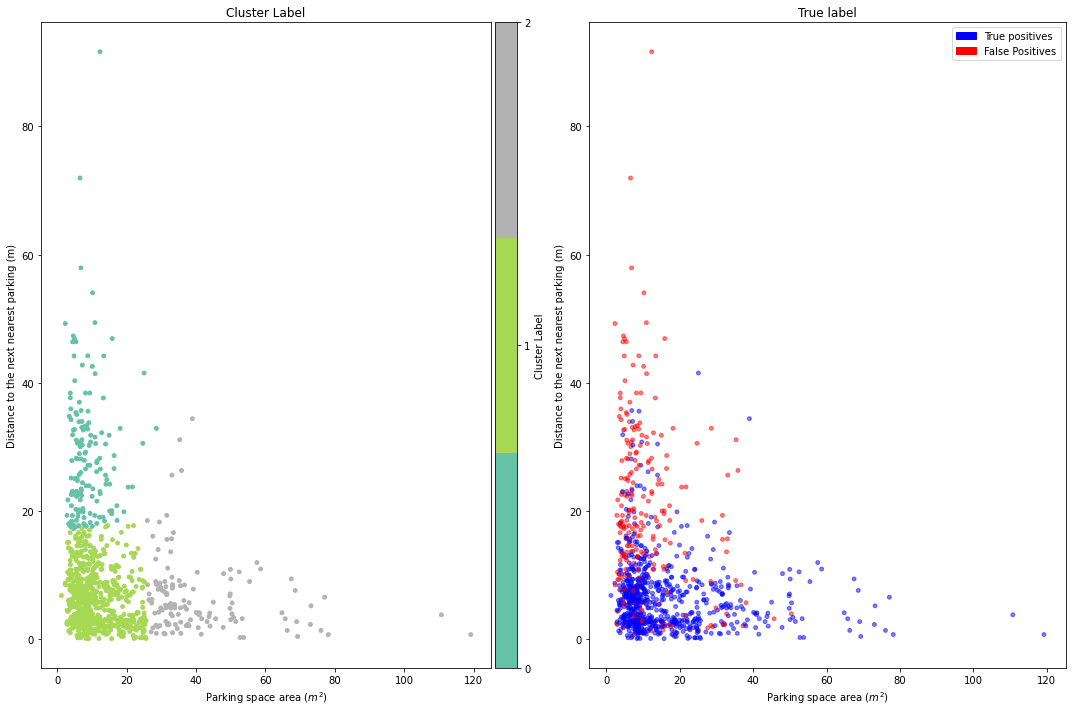

In [16]:
draw_plots(3)